# Visualizing Interpolation using GridDS

- Following from the previous example [interpolation experiment](https://gridds.readthedocs.io/en/public_091422/autoregression.html) we now demonstrate how to use gridds visualization tools to inspect the results of forecasted data.
- Here we use synthetic data from [Smart-DS](https://www.nrel.gov/grid/smart-ds.html) and downloaded from [BetterGrids.org](https://db.bettergrids.org/bettergrids/handle/1001/94)


In [9]:
import sys
from gridds.experimenter import Experimenter
from gridds.data import SmartDS 
import gridds.viz.viz as viz_tools
import os
import matplotlib.pyplot as plt
from gridds.models import KNN, RandomForest, BayesianRidge
import gridds.tools.tasks as tasks
import shutil
import pandas as pd
import pickle

## Recap running an interpolation experiment
- Here is a brief recap on how to run the interpolation experiment with inline comments provided.

In [3]:
# run experiments from root dir ( one up)
os.chdir('../')

In [11]:

# instantiate smartDS dataset
dataset = SmartDS('univariate_nrel', sites=1, test_pct=.5, normalize=False, size=300)

# load customer data
reader_instructions = {
    'sources': ['P1U'],
    'modalities': ['load_data'],
    'target': '',  # NREL synthetic data doesn't have faults
    'replicates': ['customers']
}

# prepare x/y split of training data
dataset.prepare_data(reader_instructions)

#ablate data so we can test interpolation
dataset.remove_data(chunksize=20, chunks=3)

# compile list of methods to use
methods = []
methods += [KNN('KNN')]
methods += [ BayesianRidge('Bayesian Ridge')]
methods += [RandomForest('Random Forest')]

# run methods on task : "tasks.default_autoregression"
exp = Experimenter('interpolation_viz', runs=1)
exp.run_experiment(dataset,methods,task=tasks.default_autoregression, clean=False)


      method_name       mae     rmse
0             KNN  0.252573  0.46692
1  Bayesian Ridge  0.252573  0.46692
2   Random Forest  0.252573  0.46692


## Recover Data and Visualize Result DataFrame
- `gridds` stores data from each run in an outputs directory titled by the run number and the experiment name.
- Here we recover the basic stats of the current run such as `MAE` and `RMSE`

In [12]:
# recover results for path run 0
base_path = os.path.join('outputs','interpolation_viz', '0')
df_path = os.path.join(base_path,'results.csv')
exp_name = base_path.split('/')[-2]
df = pd.read_csv(df_path)
df

,method_name,mae,rmse
0,KNN,0.252573,0.46692
1,Bayesian Ridge,0.252573,0.46692
2,Random Forest,0.252573,0.46692


In [14]:
viz_tools.visualize_output(os.path.join('outputs', exp.name))

## Visualize Interpolation
- To save PDF/PNG versions of forecasts and other autoregression outputs one can just use the `viz_tools.visualize_output` functionality from the visualization library.
    - This will save outputs directly into `outputs/interpolation_viz` folder.
- Alternatively, this notebook will walkthrough this plotting procedure.
- Here we will plot each methods forecasts as a subplot.

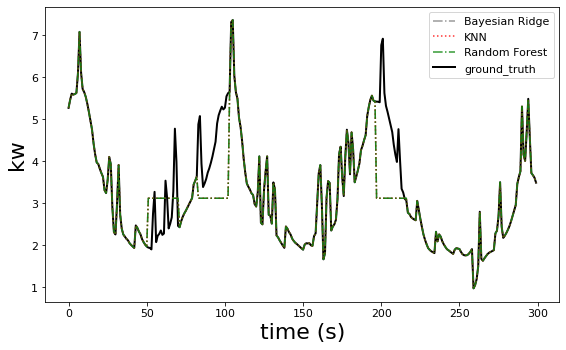

In [35]:
# set up figure to have the correct number of subplots for each method
num_methods = len([elem for elem in os.listdir(base_path) if os.path.isdir(os.path.join(base_path,elem))])
methods_fig = plt.figure(figsize=(8,5))
methods_ax = methods_fig.gca()
# set "run_num" = 0 since we did not do cross validation
run_num = 0
method_ix = 0

for method in os.listdir(base_path):
    if 'results' in method: continue # dont parse results csv
    method_dir = os.path.join(base_path, method)
    curr_data = viz_tools.load_method(base_path, method, run_num)  # load data
    if not curr_data: continue
    fig = viz_tools.plot_result(df, curr_data, method_dir, ax=methods_ax)

# title axes
methods_ax.set_xlabel('time (s)', fontsize=22)
methods_ax.set_ylabel('kw', fontsize=22)
methods_ax.plot(curr_data['ground_truth'][:,0], label='ground_truth', color='black', linewidth=2, zorder=-10)
methods_ax.legend()